In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # FFFFF

# Data loading
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

# Auxiliary functions
from torch.utils.tensorboard import SummaryWriter  # Used for Tensorboard logging
import os
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil
import datetime

import json

from dataset_semseg import SupermarketSemSeg

import matplotlib.patches as mpatches
import matplotlib.cm as cm


# Segmentación de imagen mediante arquitectura U-Net

In [2]:
PATH_ROOT = os.path.join('.')
# Ruta para datos:
PATH_DATA = os.path.join(PATH_ROOT, 'data')
# Ruta para modelos:
PATH_MODELS = os.path.join(PATH_ROOT, 'reports', 'models')
# Ruta para resultados:
PATH_RESULTS = os.path.join(PATH_ROOT, 'reports', 'results')
# Ruta para ejecuciones:
PATH_RUNS = os.path.join(PATH_ROOT, 'reports', 'runs')

In [3]:
# Para cada sesión creamos un directorio nuevo, a partir de la fecha y hora de su ejecución:
date = datetime.datetime.now()
test_name = str(date.year) + '_' + str(date.month) + '_' +  str(date.day) + '__' + str(date.hour) + '_' + str(date.minute)
print('Nombre del directorio de pruebas: {}'.format(test_name))
models_folder = os.path.join(PATH_MODELS, test_name)
try:
    os.makedirs(models_folder)
except:
    print(f'Folder {models_folder} already existed.')
results_folder = os.path.join(PATH_RESULTS, test_name)
try:
    os.makedirs(results_folder)
except:
    print(f'Folder {results_folder} already existed.')
runs_folder = os.path.join(PATH_RUNS, test_name)
try:
    os.makedirs(runs_folder)
except:
    print(f'Folder {runs_folder} already existed.')


Nombre del directorio de pruebas: 2025_11_25__13_36


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)   

cuda


## Definición del modelo

Como vamos a repetir la estructura de Convolución, Convolución, pooling, hacemos una clase para ello

In [5]:
class DoubleConv(nn.Module):
    """
    Conv3x3 -> ReLU -> Conv3x3 -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [6]:
class Down(nn.Module):
    """
    MaxPool2x2 -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


In [7]:
class Up(nn.Module):
    """
    UpConv2x2 -> concat con skip -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)  # in_channels = (up_out + skip)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


In [8]:
class OutConv(nn.Module):
    # Conv1x1 para la salida
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, base_ch=64):
        super().__init__()

        self.num_classes = num_classes

        # Encoder
        self.inc = DoubleConv(in_channels, base_ch)          # 3 -> 64
        self.down1 = Down(base_ch, base_ch * 2)              # 64 -> 128
        self.down2 = Down(base_ch * 2, base_ch * 4)          # 128 -> 256
        self.down3 = Down(base_ch * 4, base_ch * 8)          # 256 -> 512
        self.down4 = Down(base_ch * 8, base_ch * 16)         # 512 -> 1024

        self.cuello_botella = DoubleConv(base_ch * 16, base_ch * 16)

        # Decoder
        self.up1 = Up(base_ch * 16, base_ch * 8)             # 1024 -> 512
        self.up2 = Up(base_ch * 8, base_ch * 4)              # 512 -> 256
        self.up3 = Up(base_ch * 4, base_ch * 2)              # 256 -> 128
        self.up4 = Up(base_ch * 2, base_ch)                  # 128 -> 64

        # Capa final
        self.outc = OutConv(base_ch, num_classes)            # 64 -> num_clases

    def forward(self, x):
        x1 = self.inc(x)     # (B, 64, 144, 192)
        x2 = self.down1(x1)  # (B, 128, 72, 96)
        x3 = self.down2(x2)  # (B, 256, 36, 48)
        x4 = self.down3(x3)  # (B, 512, 18, 24)
        x5 = self.down4(x4)  # (B, 1024, 9, 12)

        x = self.cuello_botella(x5)
        
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)  # (B, num_clases, 144, 192)
        return logits


## Carga de Datos

Cargamos los dos conjuntos de datos (elegir)

10 clases

In [10]:
clase = "train"
root_images_train = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_train = f"./dataset_res_144_192_10classes/{clase}/masks/"

clase = "test"
root_images_test = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_test = f"./dataset_res_144_192_10classes/{clase}/masks/"

dataset_train = SupermarketSemSeg(images_dir=root_images_train, masks_dir=root_masks_train, include_filenames=True)
dataset_test = SupermarketSemSeg(images_dir=root_images_test, masks_dir=root_masks_test, include_filenames=True)

num_classes = 11

Todas las clases

In [40]:
clase = "train"
root_images_train = f"./dataset_res_144_192/{clase}/images/"
root_masks_train = f"./dataset_res_144_192/{clase}/masks/"

clase = "test"
root_images_test = f"./dataset_res_144_192/{clase}/images/"
root_masks_test = f"./dataset_res_144_192/{clase}/masks/"

dataset_train = SupermarketSemSeg(images_dir=root_images_train, masks_dir=root_masks_train, include_filenames=True)
dataset_test = SupermarketSemSeg(images_dir=root_images_test, masks_dir=root_masks_test, include_filenames=True)

num_classes = 61

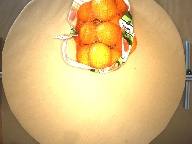

In [11]:
x = dataset_train.__getitem__(400)
mask = x["mask"]
dataset_train._read_image(p = x["image_path"])

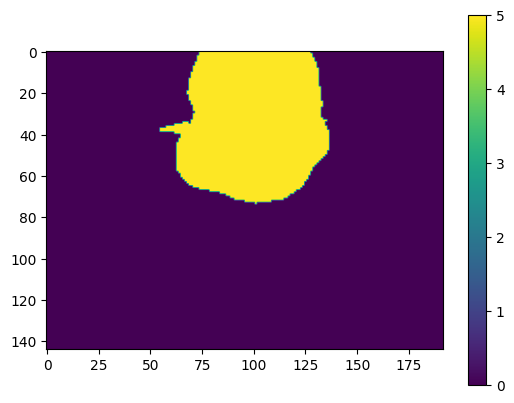

In [12]:
plt.imshow(mask.numpy())
plt.colorbar()
plt.show()

In [13]:
total_size = len(dataset_train)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(
    dataset_train, 
    [train_size, val_size], 
    generator=generator
)

batch_size = 8  # Tamaño de lotes
num_workers = 0  # Controla cuántos procesos cargan datos en paralelo (lo dejaremos a 0 para ahorrar recursos)

In [14]:
train_loader = DataLoader(
    dataset=train_dataset,      
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=val_dataset,        
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, writer=None, scheduler=None):

    train_losses = []
    val_losses = []

    num_classes = model.num_classes

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        # --------- TRAIN ---------
        for batch in train_loader:
            imgs = batch["image"].to(device)          # (B, 3, H, W)
            masks = batch["mask"].long().to(device)   # (B, H, W)

            optimizer.zero_grad()

            outputs = model(imgs)                     # (B, C, H, W)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = outputs.argmax(1)                 # (B, H, W)
            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()

        avg_train_loss = running_loss / len(train_loader)
        train_pixel_acc = running_correct / running_total
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Pixel Acc: {train_pixel_acc:.4f}")

        # TensorBoard: scalars de TRAIN
        if writer is not None:
            writer.add_scalar('train/loss', avg_train_loss, epoch)
            writer.add_scalar('train/pixel_acc', train_pixel_acc, epoch)

        # --------- VALIDACIÓN ---------
        model.eval()
        running_val_loss = 0.0
        running_val_correct = 0
        running_val_total = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):

                imgs = batch["image"].to(device)
                masks = batch["mask"].long().to(device)

                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()

                preds = outputs.argmax(1)
                running_val_correct += (preds == masks).sum().item()
                running_val_total += masks.numel()

                # ---- LOG DE IMÁGENES SOLO UNA VEZ POR EPOCH ----
                if writer is not None and batch_idx == 0 and epoch % 2 == 0:
                    imgs_cpu = imgs[:4].cpu()
                    masks_cpu = masks[:4].cpu()
                    preds_cpu = preds[:4].cpu()

                    # Figura estilo ver_prediccion
                    fig, axes = plt.subplots(4, 3, figsize=(10, 10))
                    for i in range(4):
                        img = imgs_cpu[i].permute(1, 2, 0).numpy()

                        orig  = masks_cpu[i].numpy()
                        pred  = preds_cpu[i].numpy()

                        axes[i, 0].imshow(img)
                        axes[i, 0].set_title("Imagen")
                        axes[i, 0].axis("off")

                        axes[i, 1].imshow(img)
                        axes[i, 1].imshow(orig, cmap='tab10', alpha=0.8, vmin=0, vmax=num_classes-1)
                        axes[i, 1].set_title("GT")
                        axes[i, 1].axis("off")

                        axes[i, 2].imshow(img)
                        axes[i, 2].imshow(pred, cmap='tab10', alpha=0.8, vmin=0, vmax=num_classes-1)
                        axes[i, 2].set_title("Pred")
                        axes[i, 2].axis("off")

                    plt.tight_layout()
                    writer.add_figure("val/overlay", fig, epoch)
                    plt.close(fig)


        avg_val_loss = running_val_loss / len(val_loader)
        val_pixel_acc = running_val_correct / running_val_total
        val_losses.append(avg_val_loss)

        print(f"           Val Loss: {avg_val_loss:.4f} - Val Pixel Acc: {val_pixel_acc:.4f}")
        if scheduler is not None: # CUIDADO: algunos schedulers se actualizan por epoch, otros por batch
            scheduler.step(avg_val_loss)
        # TensorBoard: scalars de VAL
        if writer is not None:
            writer.add_scalar('val/loss', avg_val_loss, epoch)
            writer.add_scalar('val/pixel_acc', val_pixel_acc, epoch)

        # Tensorboard: Histogramas de pesos y gradientes
        if writer is not None:
            for name, p in model.named_parameters():
                if p.requires_grad:
                    writer.add_histogram(f'params/{name}', p.detach().cpu(), epoch)
                    if p.grad is not None:
                        writer.add_histogram(f'grads/{name}', p.grad.detach().cpu(), epoch)

    return train_losses, val_losses


In [16]:
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch["image"].to(device)
            masks = batch["mask"].long().to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = outputs.argmax(1)
            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()
            
    avg_loss = running_loss / len(test_loader)
    pixel_acc = running_correct / running_total

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Pixel Accuracy: {pixel_acc:.4f}")

    return avg_loss, pixel_acc


In [17]:
model = UNet(
    in_channels=3,
    num_classes=num_classes,
    base_ch=64
).to(device)

Dos opciones para pesos (elegir):

In [18]:
weights = torch.ones(num_classes, device=device, dtype=torch.float)
weights[0] = 0.2 # valor arbitrario

In [19]:
num_pixels = torch.zeros(num_classes, device=device)

for batch in train_loader:
    mask = batch["mask"].to(device)
    for c in range(num_classes):
        num_pixels[c] += (mask == c).sum()

total_pixels = num_pixels.sum()
weights = total_pixels / (num_classes * num_pixels)

In [20]:
print(weights)
print(weights.shape)

tensor([ 0.1009, 34.5973,  6.4792, 31.7816, 38.8143,  3.4912,  9.8208, 27.7383,
        18.8156, 52.6706,  2.8699], device='cuda:0')
torch.Size([11])


In [21]:
criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
writer = SummaryWriter(log_dir=runs_folder)
#scheduler = None

train_losses, val_losses = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    device=device,
    scheduler=scheduler,
    writer=writer
)

Epoch 1/20 - Train Loss: 2.3480 - Train Pixel Acc: 0.1124
           Val Loss: 2.0817 - Val Pixel Acc: 0.4439
Epoch 2/20 - Train Loss: 4.8297 - Train Pixel Acc: 0.0941
           Val Loss: 2.2150 - Val Pixel Acc: 0.0297
Epoch 3/20 - Train Loss: 2.0898 - Train Pixel Acc: 0.1112
           Val Loss: 1.9687 - Val Pixel Acc: 0.2790
Epoch 4/20 - Train Loss: 1.9673 - Train Pixel Acc: 0.2309
           Val Loss: 1.8528 - Val Pixel Acc: 0.2748
Epoch 5/20 - Train Loss: 1.8873 - Train Pixel Acc: 0.2708
           Val Loss: 1.8392 - Val Pixel Acc: 0.1647
Epoch 6/20 - Train Loss: 1.7516 - Train Pixel Acc: 0.1465
           Val Loss: 1.5857 - Val Pixel Acc: 0.0752
Epoch 7/20 - Train Loss: 1.6115 - Train Pixel Acc: 0.1580
           Val Loss: 1.3926 - Val Pixel Acc: 0.7107
Epoch 8/20 - Train Loss: 1.4713 - Train Pixel Acc: 0.4864
           Val Loss: 1.3512 - Val Pixel Acc: 0.0675
Epoch 9/20 - Train Loss: 1.4021 - Train Pixel Acc: 0.1847
           Val Loss: 1.1413 - Val Pixel Acc: 0.3684
Epoch 10/2

In [25]:
test(model, test_loader, criterion, device)

Test Loss: 3.1786
Test Pixel Accuracy: 0.3043


(3.1785851659966102, 0.3042840616476457)

In [26]:
def leer_mapeado(ruta):
    with open(ruta, 'r') as f:
        data = json.load(f)
    clases = {}
    for i in range(len(data)):
        clases[data[i]['index']] = data[i]['name']
    return clases
if num_classes == 11:
    mapeado_clases = leer_mapeado('dataset_res_144_192_10classes/label_mapping_10classes.json')
else:
    mapeado_clases = leer_mapeado('dataset_res_144_192/label_mapping.json')

C:\Users\iniet\AppData\Local\Temp\ipykernel_40084\1070354964.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(mapa, num_classes)


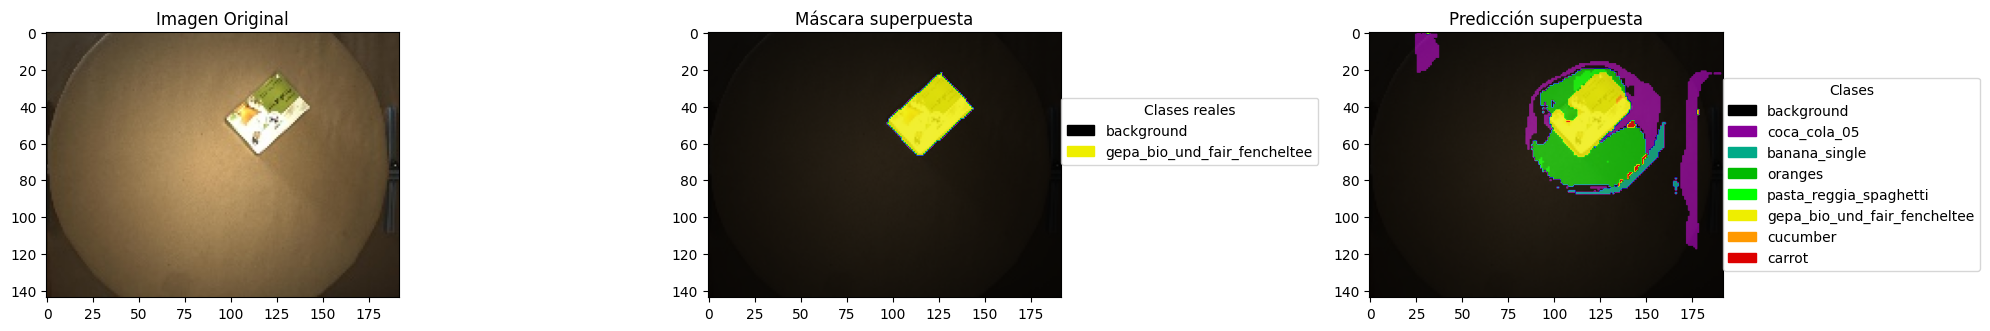

In [28]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

def ver_prediccion(indice, test = True,  alpha = 0.8, num_classes=11):
    if test:
        ejemplo = dataset_test[indice]
    else:
        ejemplo = dataset_train[indice]
    x = ejemplo["image"].to(device)
    pred = model(x.unsqueeze(0)).argmax(1).squeeze().cpu().numpy()
    mask = ejemplo["mask"].numpy()    
    mapa = "nipy_spectral"
    cmap = cm.get_cmap(mapa, num_classes)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    img = x.cpu().permute(1, 2, 0).numpy() #pasamos de (C, H, W) a (H, W, C) para poder usar matplotlib    
    axes[0].imshow(img)
    axes[0].set_title(f'Imagen Original')    
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap=mapa, vmin=0, vmax=num_classes-1, alpha=alpha) # vmin, vmax para que los colores correspondan a las clases totales (no solo las presentes)
    axes[1].set_title('Máscara superpuesta')    
    axes[2].imshow(img)
    axes[2].imshow(pred, cmap=mapa, vmin=0, vmax=num_classes-1, alpha=alpha)
    axes[2].set_title('Predicción superpuesta')    

    # Leyenda para la máscara original
    clases_mask = np.unique(mask)
    patches_mask = [mpatches.Patch(color=cmap(i), label=mapeado_clases[i]) for i in clases_mask]
    axes[1].legend(handles=patches_mask, loc=[1,0.5],
                   title='Clases reales')

    # Leyenda para la predicción
    clases_presentes = np.unique(pred)
    patches = [mpatches.Patch(color=cmap(i), label=mapeado_clases[i]) for i in clases_presentes]
    plt.legend(handles=patches, loc=[1,0.1],
            title='Clases')    
    plt.tight_layout()
    plt.show()

ver_prediccion(0, test=False)

